In [1]:
%matplotlib inline

In [ ]:
import numpy as np
import torch
torch.set_printoptions(edgeitems=2,linewidth=75)

import matplotlib.pyplot as plt


In [3]:
t_c = [0.5,14.0,15.0,28.0,11.0,8.0,3.0,-4.0,6.0,13.0,21.0]
t_u = [35.7,55.9,58.2,81.9,56.3,48.9,33.9,21.8,48.4,60.4,68.4]

t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)
t_u.shape,t_c.shape

(torch.Size([11]), torch.Size([11]))

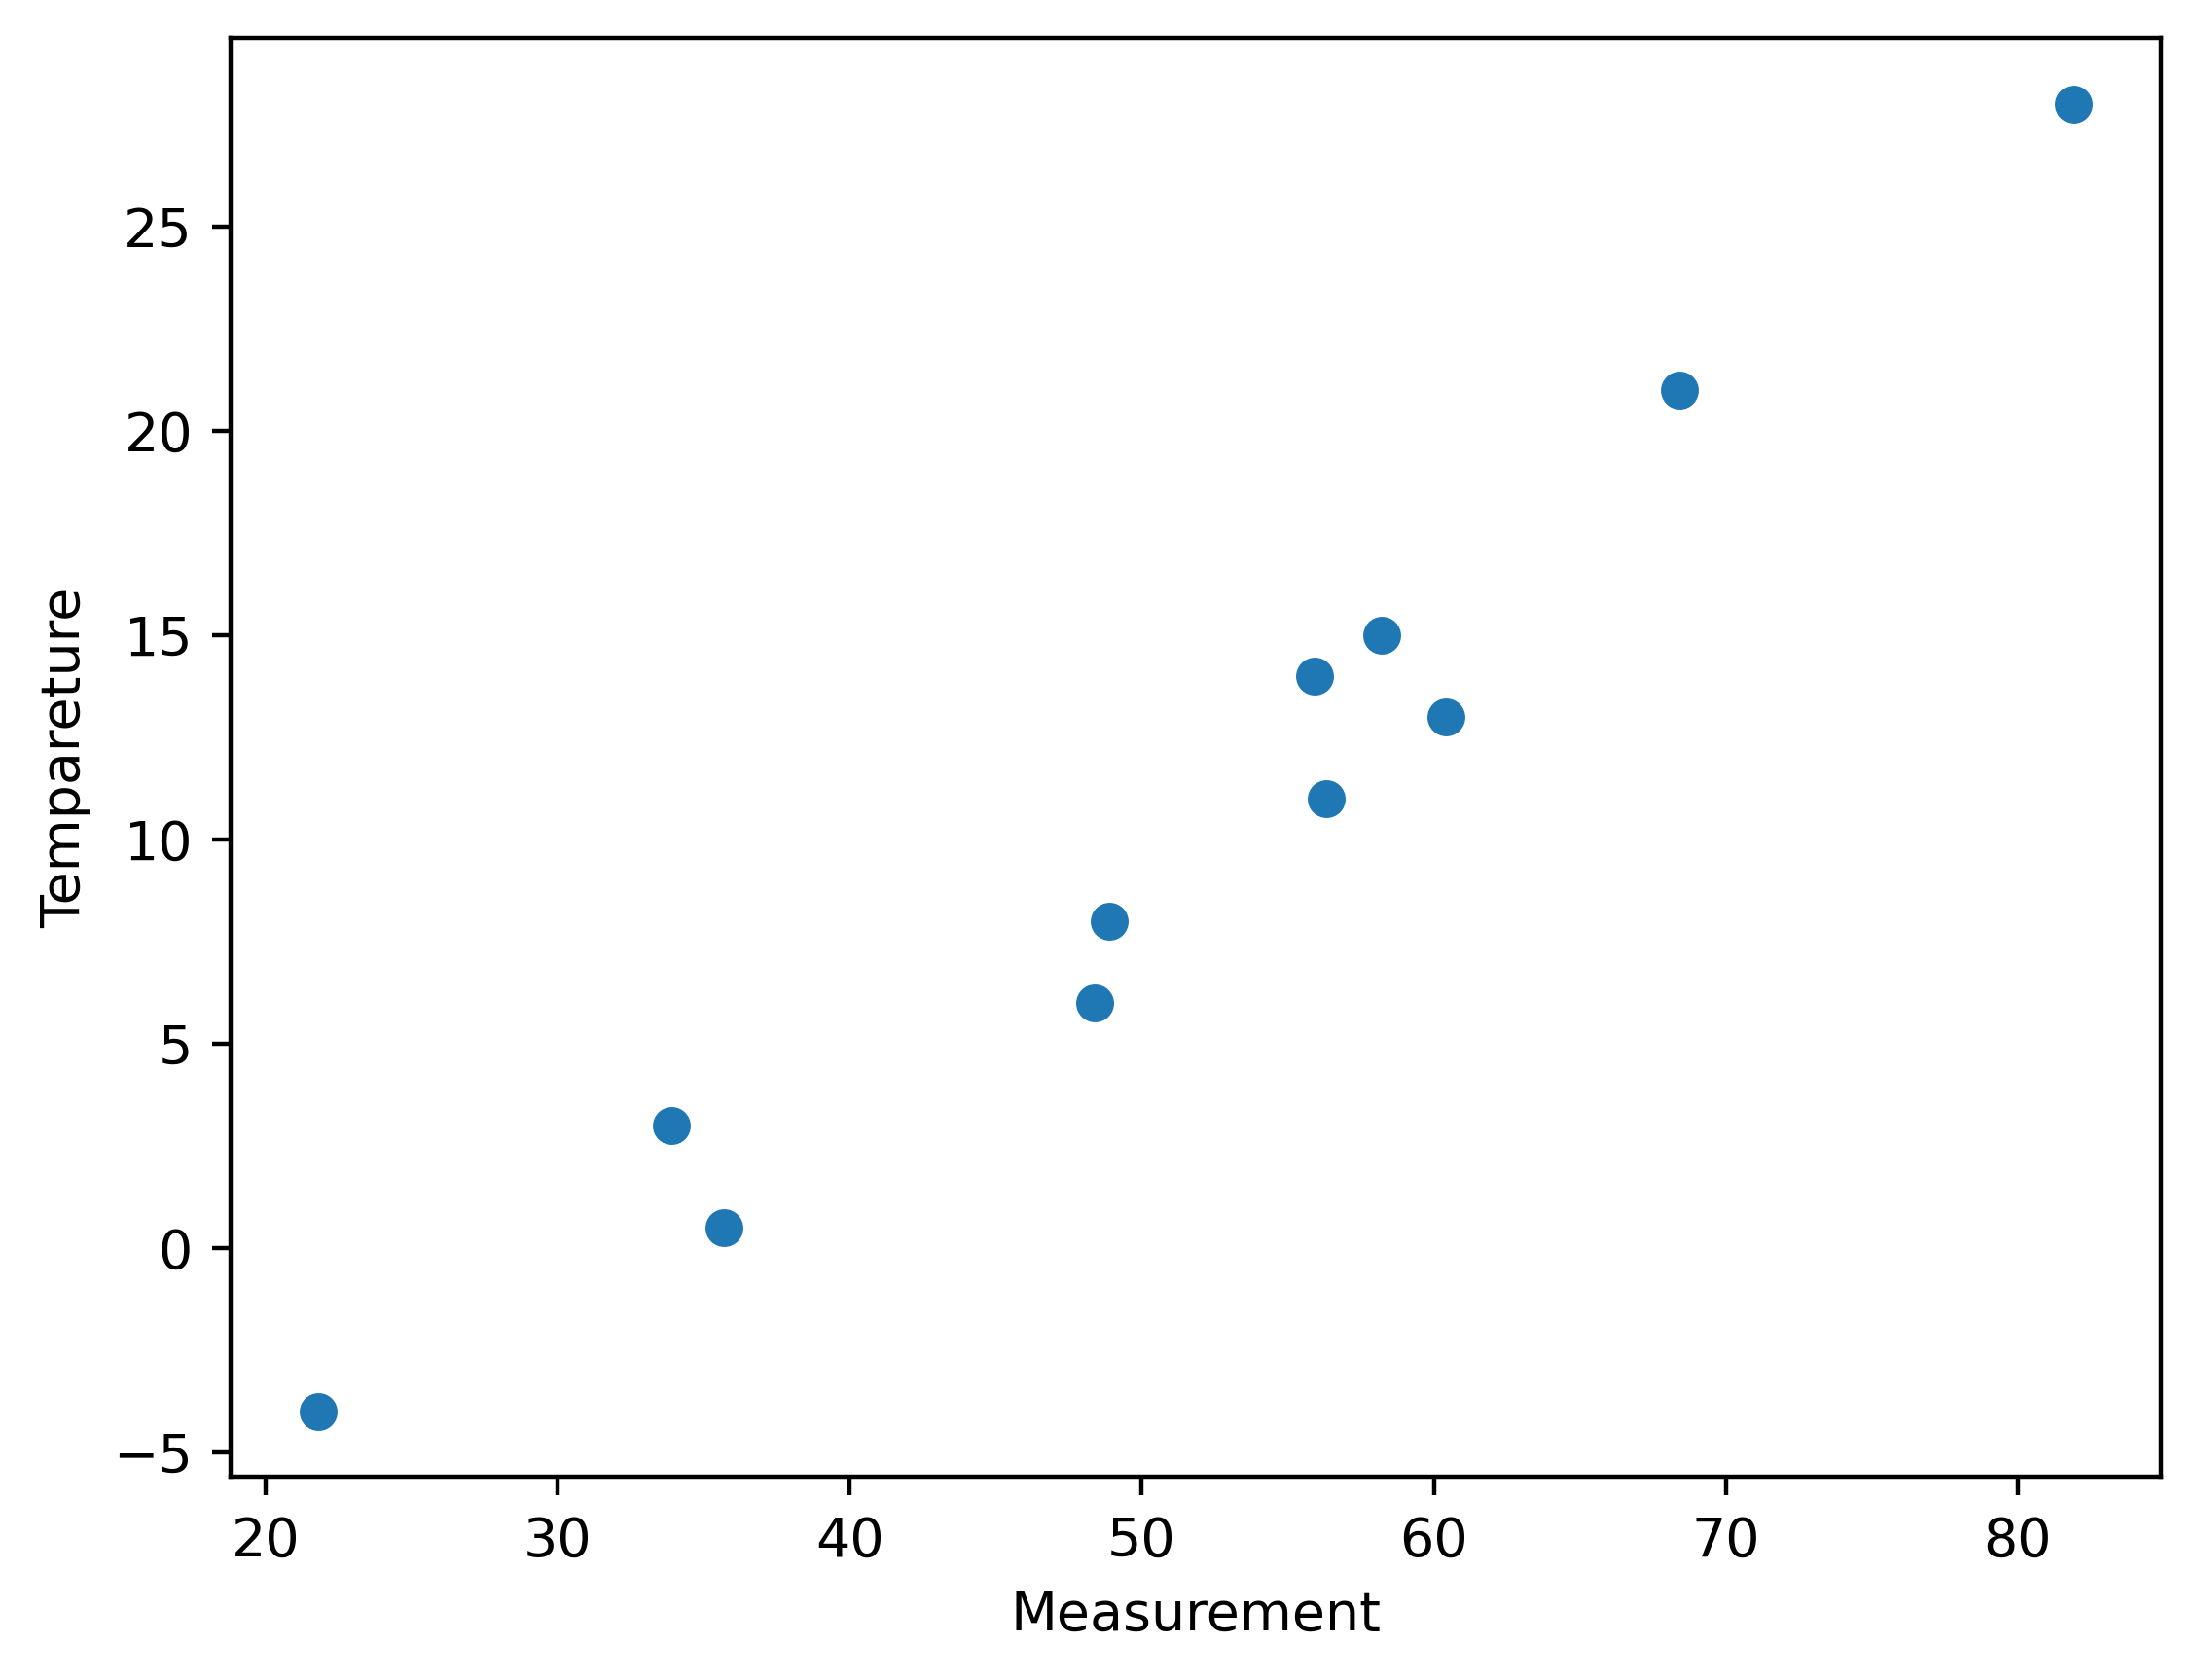

In [5]:
flg = plt.figure(dpi=400)
plt.xlabel("Measurement")
plt.ylabel("Tempareture")
plt.plot(t_u.numpy(),t_c.numpy(),'o')

plt.savefig("temp_data_plot.png",format=('png'))

In [6]:
def model(t_u,w,b):
    return w * t_u +b

In [7]:
def loss_fn(t_p,t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [8]:
w = torch.ones(())
b = torch.zeros(())
w,b

(tensor(1.), tensor(0.))

In [9]:
t_p = model(t_u,w,b)
t_p,t_c

(tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
         21.8000, 48.4000, 60.4000, 68.4000]),
 tensor([ 0.5000, 14.0000, 15.0000, 28.0000, 11.0000,  8.0000,  3.0000,
         -4.0000,  6.0000, 13.0000, 21.0000]))

In [10]:
loss = loss_fn(t_p,t_c)
loss

tensor(1763.8848)

In [11]:
delta = 0.1
loss_rate_of_change_w = \
    (loss_fn(model(t_u,w+delta,b),t_c)-
     loss_fn(model(t_u,w-delta,b),t_c))/(2.0*delta)
loss_rate_of_change_w

tensor(4517.2974)

In [12]:
leaning_rate = 1e-2
w = w -leaning_rate * loss_rate_of_change_w

In [13]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u,w,b+delta),t_c)-
     loss_fn(model(t_u,w,b-delta),t_c))/(2.0*delta)

loss_rate_of_change_b

tensor(-4600.)

In [14]:
b = b - leaning_rate * loss_rate_of_change_b

In [17]:
def dloss_fn(t_p,t_c):
    dsq_diffs = 2 * (t_p-t_c)/t_p.size(0)
    return dsq_diffs

t_p.size(0)

11

In [20]:
def dmodel_dw(t_u, w, b):
    return t_u
def dmodel_db(t_u, w, b):
    return 1.0

In [23]:
#梯度理解：梯度就是损失函数对于参数的偏导数
'''链式法则：loss = loss_fn(t_p,t_c) t_p = model(t_u,w,b)
def loss_fn(t_p,t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()
要求loss 函数对于w的偏导数，先要求loss_fn对于t_p-t_c的偏倒数dloss_dtp
再求 t_p 对于 w的 偏倒数 。b参数也是同样
'''
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])  # <1>


# torch.stack[]例子
# # 创建两个张量
# tensor1 = torch.tensor([1, 2, 3])
# tensor2 = torch.tensor([4, 5, 6])
# # 使用torch.stack将两个张量在维度0上进行堆叠
# stacked_tensor = torch.stack([tensor1, tensor2], dim=0)
#
# print(stacked_tensor)
# tensor([[1, 2, 3],
#         [4, 5, 6]])


In [24]:
def traing_loop(n_epochs,leaning_rate,params,t_u,t_c):
    for epoch in range(1,n_epochs+1):
        w,b = params

        t_p= model(t_u,w,b)
        loss = loss_fn(t_p,t_c)
        grad = grad_fn(t_u,t_c,t_p,w,b)

        params = params - leaning_rate*grad

        print('epoch %d, loss %f '% (epoch,float(loss)))

    return params

In [30]:
def training_loop(n_epochs,learning_rate,params,t_u,t_c,
                  print_params = True):
    for epoch in range(1, n_epochs+1):
        w, b = params
        t_p = model(t_u,w,b)
        loss = loss_fn(t_p,t_c)
        grad = grad_fn(t_u,t_c,t_p,w,b)

        params = params -learning_rate* grad

        if epoch in {1,2,3,10,11,99,100,4000,5000}:
            print('epoch %d Loss %f '% (epoch,float(loss)))
            if print_params:
                print('    Params:',params)
                print('    Grad:  ',grad)
        if epoch in {4,12,101}:
            print('...')

        if not torch.isfinite(loss).all():
            break

    return params

In [33]:
training_loop(n_epochs=100,
              learning_rate=1e-2,#1e-2
              params=torch.tensor([1.0,0.0]),
              t_u =t_u,
              t_c = t_c)

epoch 1 Loss 1763.884766 
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2964,   82.6000])
epoch 2 Loss 323.090515 
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
epoch 3 Loss 78.929634 
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4666,  16.5122])
...
epoch 10 Loss 29.105247 
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
epoch 11 Loss 29.104168 
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
epoch 99 Loss 29.023582 
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
epoch 100 Loss 29.022667 
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

In [34]:
# 梯度爆炸两种解决方式，
# 1：减小学习率，将1e-2 改成1e-4
# 2 调整输入t_u的大小，常见的为标准化，使得t_u数值在一个合适的区间

#个人理解，调整t_u是为了初步粗略使得被预测目标接近实际值，即使得t_u 靠近t_c

In [35]:
t_un = 0.1 * t_u

In [36]:
training_loop(
    n_epochs = 100,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un, # <1>
    t_c = t_c)

epoch 1 Loss 80.364342 
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
epoch 2 Loss 37.574913 
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
epoch 3 Loss 30.871077 
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
epoch 10 Loss 29.030489 
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
epoch 11 Loss 28.941877 
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
epoch 99 Loss 22.214186 
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
epoch 100 Loss 22.148710 
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

In [37]:
params = training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un,
    t_c = t_c,
    print_params = False)

params

epoch 1 Loss 80.364342 
epoch 2 Loss 37.574913 
epoch 3 Loss 30.871077 
...
epoch 10 Loss 29.030489 
epoch 11 Loss 28.941877 
...
epoch 99 Loss 22.214186 
epoch 100 Loss 22.148710 
...
epoch 4000 Loss 2.927680 
epoch 5000 Loss 2.927648 


tensor([  5.3671, -17.3012])

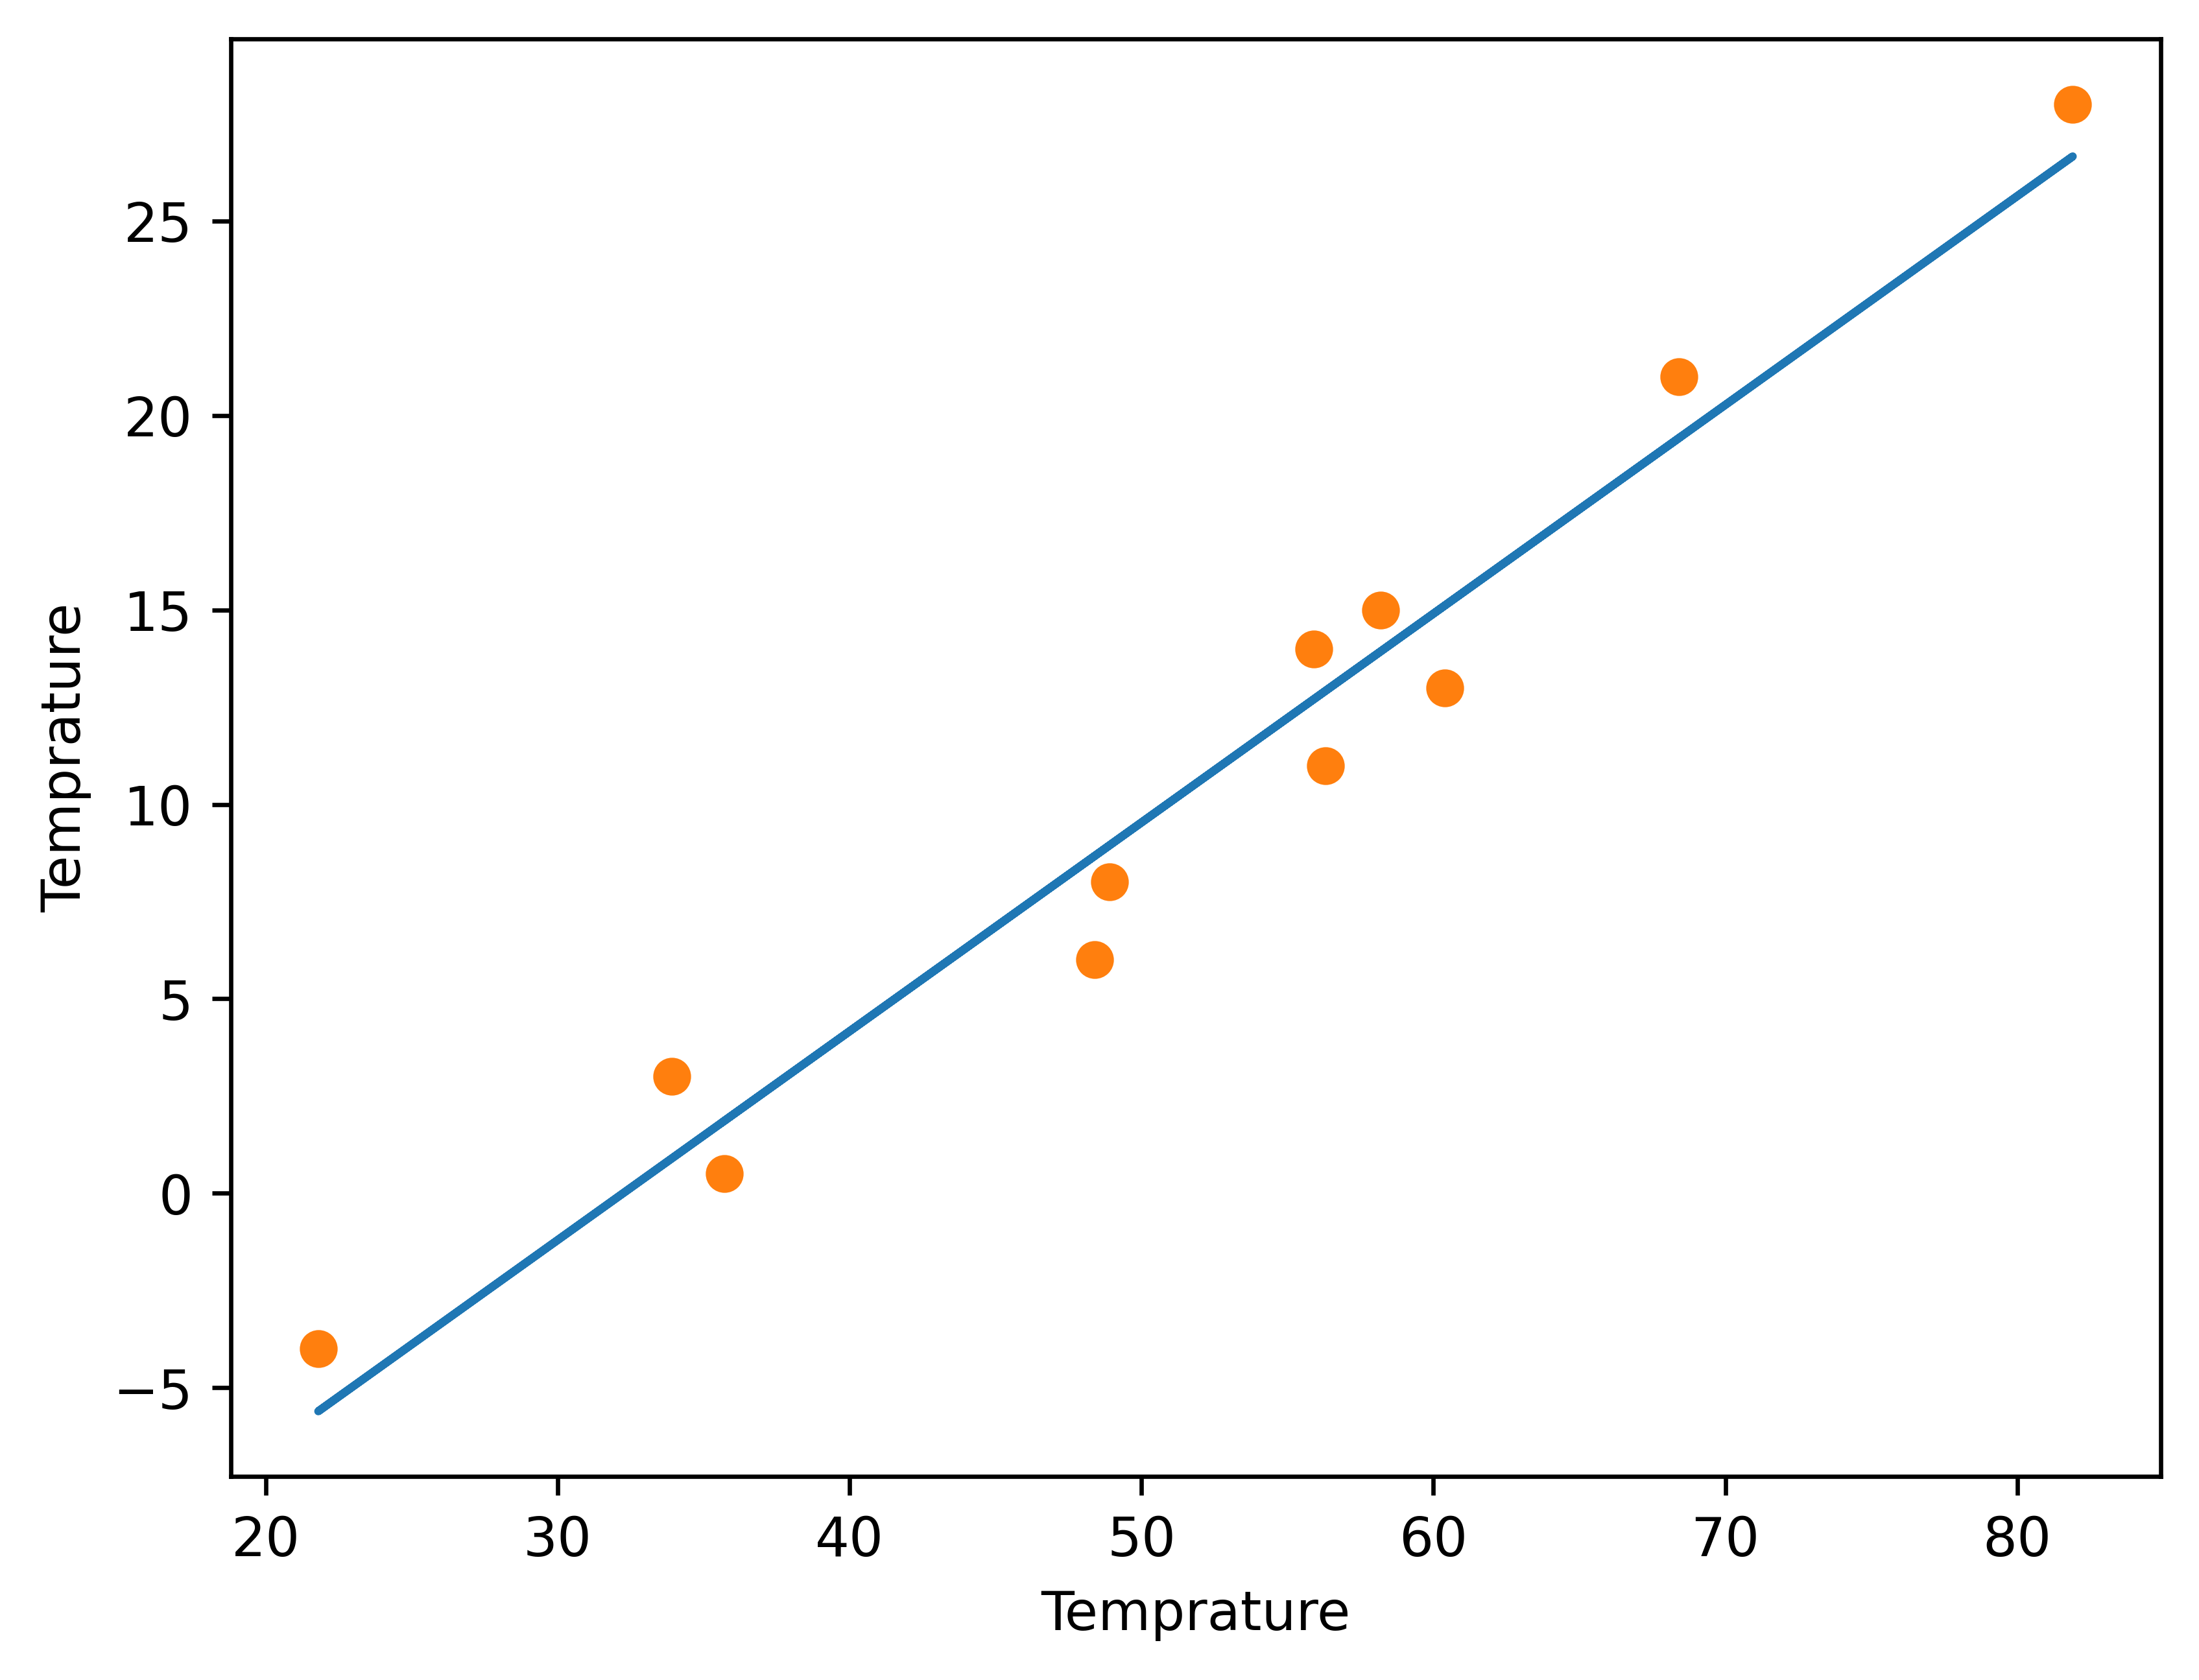

In [38]:
%matplotlib inline
from matplotlib import pyplot as plt
t_p = model(t_un,*params)
fig =plt.figure(dpi=600)
plt.xlabel("Temprature")
plt.ylabel("Temprature")
plt.plot(t_u.numpy(),t_p.detach().numpy())#detach分离
plt.plot(t_u.numpy(),t_c.numpy(),'o')
plt.savefig("temp_unknown_plot.png",format='png')